### <p style="font-family: Arial; color: gold; font-weight: bold;">**update by Tom Tan in 8.30.2024** </p>

# **1. Imports**
##### Brittany C. Haas and Melissa A. Hardy's jupyter notebook for automated collection of molecular descriptors and post-processing (i.e., Boltzmann average, min/max values, etc.).
##### **NOTE: Make sure to use the requirements.txt file to set your conda environment.**

In [1]:
import os, sys, re, io, glob, shutil
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import ColorConverter

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

import ipywidgets as widgets

common_structure_folder = "1.common_structure"
log_files_folder = "2.log_files"
sdf_files_folder = "3.sdf_files"
temp_folder = "temp"
output_folder = "4.atom_mappings"

os.makedirs(common_structure_folder, exist_ok=True)
os.makedirs(log_files_folder, exist_ok=True)
os.makedirs(sdf_files_folder, exist_ok=True)
os.makedirs(temp_folder, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)

***
# **2. Generate Atom Inputs Dataframe**
##### Portions of this section were adapted from code written Jordan P. Liles.

### <p style="font-family: Arial; color: red; font-weight: bold;"> !!! Name the same type of molecule in a unique common prefix (need to be all character) to use the following cell </p>
### <p style="font-family: Arial; color: gold; font-weight: bold;"> for example pyridine all in pyrd + digit + whatever, pyrimidine all in pyrmd + digit + whatever </p>

## &emsp;**2.1 Generate dataframe with atom numbers**
### &emsp;&emsp;Two method: <br /> &emsp;&emsp;**1. Use command line to prepare files (only in linux!)**

### &emsp;&emsp;&emsp;To create files: navigate to folder that contains all the log files you wish to analyze.

> ##### &emsp;&emsp;&emsp;module load openbabel<br /> &emsp;&emsp;&emsp;obabel *.log -osdf -m<br /> &emsp;&emsp;&emsp;ls *.log > log_ids.txt<br /> &emsp;&emsp;&emsp;cat *.sdf >> molecules.sdf<br />

##### &emsp;&emsp;&emsp;You will use the log_ids.txt and molecules.sdf files in the rest of 2.1.

### &emsp;&emsp;**2. Run the following code in python (work in windows and linux)**
##### <p style="font-family: Arial; color: red; font-weight: bold;">&emsp;&emsp;&emsp;!!!!! make sure to install openbabel.</p> &emsp;&emsp;&emsp;see https://openbabel.org/docs/Installation/install.html <br /> &emsp;&emsp;&emsp;(in ubuntu run sudo apt install openbabel), <br /> &emsp;&emsp;&emsp;testing you installation by running obable in shell

##### &emsp;&emsp;&emsp;Convert log to sdf

In [2]:
# if under linux, execute the "module load openbabel" in the terminal (seem like this is needed in some hpc server)
if sys.platform == "linux" or sys.platform == "linux2":
    !module load openbabel

# call obabel on all log files under 2.log_files folder
# first delete every *.sdf files in the current folder and in the sdf_files_folder
for file in glob.glob("*.sdf"):
    os.remove(file)
for file in glob.glob("*.sdf", root_dir=sdf_files_folder):
    os.remove(os.path.join(sdf_files_folder, file))

# call obabel on all log files under 2.log_files folder, output will be in the current folder
!obabel 2.log_files/*.log -osdf -m

# move all *.sdf files in the current folder to 3.sdf_files folder
os.makedirs(sdf_files_folder, exist_ok=True)
# move to sdf_files_folder
for file in glob.glob("*.sdf"):
    shutil.move(file, os.path.join(sdf_files_folder, file))

35 molecules converted
35 files output. The first is pyrd10_conf-1_anion.sdf


##### list all *.log files in the directory

In [3]:
# list all *.log files in the directory
# we will first grep all the prefix, use regular expression to match all non-digit characters from the start of the filename
# the key will be the prefix, and the value will be a list of all the files with that prefix
log_prefix = {}
log_file_list = glob.glob("*.log", root_dir=log_files_folder)
for file in log_file_list:
    key = re.search(r"^(\D+)\d+", file)
    if key and key.group(1) in log_prefix:
        log_prefix[key.group(1)].append(file)
    else:
        log_prefix[key.group(1)] = [file]
        
        
# sort the dict by name, using regex ^\D+(\d+) to match the number in the filename
for each in log_prefix:
    log_prefix[each].sort(key=lambda x: int(re.search(r"^\D+(\d+)", x).group(1)))
# sort the key of the dict
log_prefix = dict(sorted(log_prefix.items()))

def format_dict_print(data):
    max_key_length = max(len(key) for key in data)
    for key, value in data.items():
        print(f'"{key}": {" " * (max_key_length - len(key))}{value}')
format_dict_print(log_prefix)

"pyrd":  ['pyrd1_conf-1_anion.log', 'pyrd2_conf-1_anion.log', 'pyrd3_conf-1_anion.log', 'pyrd4_conf-1_anion.log', 'pyrd5_conf-1_anion.log', 'pyrd6_conf-1_anion.log', 'pyrd7_conf-1_anion.log', 'pyrd8_conf-1_anion.log', 'pyrd9_conf-1_anion.log', 'pyrd10_conf-1_anion.log', 'pyrd11_conf-1_anion.log', 'pyrd12_conf-1_anion.log', 'pyrd13_conf-1_anion.log', 'pyrd14_conf-1_anion.log', 'pyrd15_conf-1_anion.log', 'pyrd16_conf-1_anion.log', 'pyrd17_conf-1_anion.log', 'pyrd18_conf-1_anion.log']
"pyrdz": ['pyrdz1_conf-1_anion.log', 'pyrdz2_conf-1_anion.log', 'pyrdz3_conf-1_anion.log']
"pyrmd": ['pyrmd1_conf-1_anion.log', 'pyrmd2_conf-1_anion.log', 'pyrmd3_conf-2_anion.log', 'pyrmd4_conf-1_anion.log', 'pyrmd5_conf-1_anion.log', 'pyrmd6_conf-1_anion.log', 'pyrmd7_conf-1_anion.log', 'pyrmd8_conf-1_anion.log', 'pyrmd9_conf-1_anion.log', 'pyrmd10_conf-1_anion.log']
"pyrz":  ['pyrz1_conf-1_anion.log', 'pyrz2_conf-1_anion.log', 'pyrz3_conf-1_anion.log', 'pyrz4_conf-1_anion.log']


##### generate log_ids_prefix.txt for each prefix by writing all log filename into a single file name log_ids_ + prefix + .txt

In [4]:
# generate log_ids_prefix.txt for each prefix, save to temp folder
output_file_prefix = "log_ids_"
for key in log_prefix:
    with open(temp_folder + os.sep + output_file_prefix + key + ".txt", "w") as f:
        for item in log_prefix[key]:
            f.write("%s\n" % item)

##### list all sdf files in the directory, pipe content of those with a common prefix to a file name molecules_prefix.sdf

In [5]:
# list all sdf files in the directory, pipe those with a common prefix to a file name molecules_prefix.sdf

# we will first grep all the prefix, use regular expression to match all non-digit characters from the start of the filename
# the key will be the prefix, and the value will be a list of all the files with that prefix
sdf_prefix = {}
log_file_list = glob.glob("*.sdf", root_dir=sdf_files_folder)
for file in log_file_list:
    key = re.search(r"^(\D+)\d+", file)
    # check this against the key of prefix dictionary, if not present, skip
    if key and key.group(1) in log_prefix:
        if key.group(1) in sdf_prefix:
            sdf_prefix[key.group(1)].append(file)
        else:
            sdf_prefix[key.group(1)] = [file]

# sort the dict by name, using regex ^\D+(\d+) to match the number in the filename
for each in sdf_prefix:
    sdf_prefix[each].sort(key=lambda x: int(re.search(r"^\D+(\d+)", x).group(1)))
# sort the key of the dict
sdf_prefix = dict(sorted(sdf_prefix.items()))

format_dict_print(sdf_prefix)

# read the sdf files, pipe their contents to a single file named molecules_prefix.sdf
output_file_prefix = "molecules_"
for key in sdf_prefix:
    with open(temp_folder + os.sep + output_file_prefix + key + ".sdf", "w") as f:
        for sdf_file in sdf_prefix[key]:
            with open(sdf_files_folder + os.sep + sdf_file, "r") as f2:
                f.write(f2.read())
            print(f"pipe {sdf_file} -> {output_file_prefix + key}.sdf")

"pyrd":  ['pyrd1_conf-1_anion.sdf', 'pyrd2_conf-1_anion.sdf', 'pyrd3_conf-1_anion.sdf', 'pyrd4_conf-1_anion.sdf', 'pyrd5_conf-1_anion.sdf', 'pyrd6_conf-1_anion.sdf', 'pyrd7_conf-1_anion.sdf', 'pyrd8_conf-1_anion.sdf', 'pyrd9_conf-1_anion.sdf', 'pyrd10_conf-1_anion.sdf', 'pyrd11_conf-1_anion.sdf', 'pyrd12_conf-1_anion.sdf', 'pyrd13_conf-1_anion.sdf', 'pyrd14_conf-1_anion.sdf', 'pyrd15_conf-1_anion.sdf', 'pyrd16_conf-1_anion.sdf', 'pyrd17_conf-1_anion.sdf', 'pyrd18_conf-1_anion.sdf']
"pyrdz": ['pyrdz1_conf-1_anion.sdf', 'pyrdz2_conf-1_anion.sdf', 'pyrdz3_conf-1_anion.sdf']
"pyrmd": ['pyrmd1_conf-1_anion.sdf', 'pyrmd2_conf-1_anion.sdf', 'pyrmd3_conf-2_anion.sdf', 'pyrmd4_conf-1_anion.sdf', 'pyrmd5_conf-1_anion.sdf', 'pyrmd6_conf-1_anion.sdf', 'pyrmd7_conf-1_anion.sdf', 'pyrmd8_conf-1_anion.sdf', 'pyrmd9_conf-1_anion.sdf', 'pyrmd10_conf-1_anion.sdf']
"pyrz":  ['pyrz1_conf-1_anion.sdf', 'pyrz2_conf-1_anion.sdf', 'pyrz3_conf-1_anion.sdf', 'pyrz4_conf-1_anion.sdf']
pipe pyrd1_conf-1_anion.sdf

***
# **3.Define SMARTS substructure**

### <p style="font-family: Arial; color: gold"> Draw the common substructure (with general atoms) in Chemdraw and copy as SMILES (this will generate a SMARTS string), edit the common_structure_list.

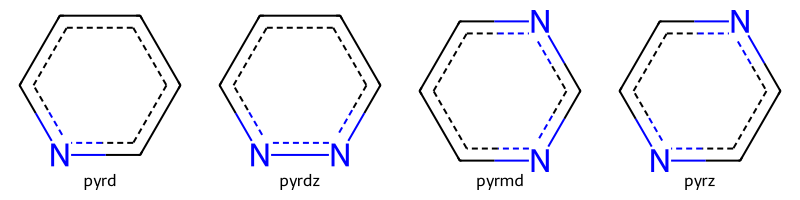

In [6]:
common_structure_list = {}

for key in log_prefix:
    structure_file = common_structure_folder + os.sep + key + ".cdxml"
    substructure = Chem.MolsFromCDXMLFile(structure_file)
    temp_smarts = Chem.MolToSmarts(substructure[0]) # convert to Smarts
    # reparse from Smarts, this is in case the structure from the cdxml file is not the same as from the SMILES string
    substructure = Chem.MolFromSmarts(temp_smarts)
    # add the substructure to the dictionary
    common_structure_list[key] = substructure

# Generate a grid image for the common structures
img = Chem.Draw.MolsToGridImage(
    list(common_structure_list.values()), molsPerRow=4, subImgSize=(200, 200), legends=list(common_structure_list.keys())
)
# Display the grid of images
display(img)

## &emsp;**3.1 Generate preliminary dataframe**
#### &emsp; This will generate common_structure_ + prefix .png with the common structure highlight and labeled. <br> &emsp; This label is the same as the one in GaussView so you don't need to use GaussView now. <br> &emsp; it will also output a dataframe mapping the common structure atom to the corresponding atom label in GaussView for easier atom reassignment.
#### <p style="font-family: Arial; color: red; font-weight: bold;"> &emsp; !!!Be aware: I add the atom label in each cell for easier atom reassignment. For example a cell change from just a single number from 7 to C7. You might need to adjust you code if you are only expecting number in each cell</p>

##### example with common_structure_pyrz.png <br> ![common_structure_pyrz](temp/common_structure_pyrz.png)

In [7]:
# load the combined sdf file using SDMolSupplier
all_compounds_list = {}
for prefix in log_prefix:
    all_compounds_list[prefix] = Chem.SDMolSupplier(
        temp_folder + os.sep + "molecules_" + prefix + ".sdf", removeHs=False
    )
# molecules.sdf is generated with the instructions above
# it is a single sdf that contains all the structures/atom numbers etc. for every molecule we will analyze


def draw_grid_image(img_list, title_list, num_cols, item_prefix, save_image_prefix):
    num_images = len(img_list)
    num_rows = (
        num_images + num_cols - 1
    ) // num_cols  # Calculate number of rows needed

    plt.figure(figsize=(15, 5 * num_rows))

    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img_list[i])
        plt.axis("on")  # Turn on the axis to show grid lines
        plt.grid(True)  # Enable grid lines
        plt.title(title_list[i], fontsize=20)
        plt.xticks([])  # Remove x-ticks
        plt.yticks([])  # Remove y-ticks

    plt.tight_layout() # tight layout
    plt.savefig(temp_folder + os.sep + save_image_prefix + item_prefix + ".png") # save the grid image to temp folder
    plt.close()


def search_for_substructure(all_compounds, substructure, prefix):
    # uses RDKit to search for the substructure in each compound you will analyze
    atoms = []
    img_list = []
    for molecule in all_compounds:
        if molecule is not None:
            submatch = molecule.GetSubstructMatches(substructure)  # find substructure
            matchlist = list([item for sublist in submatch for item in sublist])  # list of zero-indexed atom numbers

            # !this is specific to this project which is chlorination on the alkyl side chain on the substrucutre, where we care about the alkyl side chain
            # search atoms that are connected to the found substructure, which are also not part of the current substructure
            # they must be a carbon atom and it have to have at least one hydrogen neighbors and all bond must be single bond
            connected_atoms = []
            for atom in matchlist:
                for neighbor in molecule.GetAtomWithIdx(atom).GetNeighbors():
                    # filter neighbor that is not in the matchlist
                    if (neighbor.GetSymbol() == "C" and neighbor.GetIdx() not in matchlist):
                        # check if all the bonds are single bond
                        if (neighbor.GetBonds() is not None  # check if there is a bond
                            and neighbor.GetTotalNumHs(includeNeighbors=True) > 0  # check if there is at least one hydrogen
                            and all([bond.GetBondType() == Chem.rdchem.BondType.SINGLE for bond in neighbor.GetBonds()])  # check if all bonds are single bond
                        ):
                            # the atom now is the ipso carbon, the neighbor is the benzylic carbon
                            connected_atoms.append(atom)
                            connected_atoms.append(neighbor.GetIdx())
                            # we don't add they right now to the matchlist, in case the top loop is not finished
                            
                            matchlist.remove(atom) # drop the ipso carbon from matchlist for duplicate
                            # get all hydrogens atom index of this neighbor
                            hydrogens = [atom.GetIdx() for atom in neighbor.GetNeighbors() if atom.GetSymbol() == "H"]
                            hydrogens.sort()
                            # add only the first hydrogen atoms index to the connected_atoms list
                            connected_atoms.append(hydrogens[0])

            # append connected_atoms to the matchlist, which will fix the position of the ipso carbon, benzylic carbon, and the hydrogen atom at the end of the matchlist
            matchlist.extend(connected_atoms)

            match_atom_symbol = [molecule.GetAtomWithIdx(x).GetSymbol() for x in matchlist]  # find atom symbols
            match_idx = [x + 1 for x in matchlist]  # changes from 0-indexed to 1-indexed (for Gaussian view)
            match_combined = [str(match_atom_symbol[i]) + str(match_idx[i]) for i in range(len(match_atom_symbol))]  # combine atom symbol and number

            atoms.append(match_combined)  # append 1-indexed list to atoms (a list of lists)

            # add a label to the atom that is being matched
            for atom in matchlist:
                molecule.GetAtomWithIdx(atom).SetProp("atomLabel", match_combined[matchlist.index(atom)])  # label the atom being matched

            # now create a grid image of all the molecules, label the atom being matched
            # the atom that had the property name GaussianMap added to it will be labeled
            # we will draw each molecule with the atom number labeled and the substructure highlighted and then combine them into a grid image with captions of the file name
            Chem.rdDepictor.Compute2DCoords(molecule)

            # Prepare the highlight color dictionary
            # last item in the matchlist is the hydrogen atom, the second last is the benzylic carbon
            # the third last is the ipso carbon, the rest are the ring atoms
            highlight_colors = {}
            for atom in matchlist[:-3]:
                highlight_colors[atom] = ColorConverter().to_rgba("Pink", alpha=0.8)
            for atom in matchlist[-3:-2]:
                highlight_colors[atom] = ColorConverter().to_rgba("Gold", alpha=0.8)
            for atom in matchlist[-2:-1]:
                highlight_colors[atom] = ColorConverter().to_rgba("Green", alpha=0.8)
            for atom in matchlist[-1:]:
                highlight_colors[atom] = ColorConverter().to_rgba(
                    "DeepSkyBlue", alpha=0.8
                )

            # Create a drawer
            drawer = Chem.Draw.rdMolDraw2D.MolDraw2DCairo(
                500, 500
            )  # Use Cairo backend for drawing
            drawer.drawOptions().continuousHighlight = True
            # Prepare highlight dictionary
            drawer.DrawMolecule(
                molecule, highlightAtoms=matchlist, highlightAtomColors=highlight_colors
            )
            drawer.FinishDrawing()

            png_data = drawer.GetDrawingText()
            img = Image.open(io.BytesIO(png_data))
            img_list.append(img)

    # this loop extracts log names from log_ids and splits them to the desired format
    filenames = open(temp_folder + os.sep + "log_ids_" + prefix + ".txt", "r")
    # it is a text file that contains the file name for every molecule you will analyze
    list_of_filenames = [
        (line.strip()).split() for line in filenames
    ]  # list of the file names (each of which includes all conformers)
    list_of_files = []
    for filename in list_of_filenames:
        file = filename[0].split(".")
        list_of_files.append(file[0])
    filenames.close()

    # put the atom numbers for the substructure for each log file into a dataframe
    prelim_df = pd.DataFrame(atoms)
    prelim_df.insert(0, column="log_name", value=list_of_files)

    draw_grid_image(img_list, list_of_files, 3, prefix, "common_structure_")

    return prelim_df


mappped_df = {}

for prefix in log_prefix:
    mappped_df[prefix] = search_for_substructure(
        all_compounds_list[prefix], common_structure_list[prefix], prefix
    )
    display(mappped_df[prefix])

,log_name,0,1,2,3,4,5,6,7
0,pyrd1_conf-1_anion,C5,C4,N3,C11,C10,C2,C1,H12
1,pyrd2_conf-1_anion,C11,N10,C9,C4,C3,C2,C1,H12
2,pyrd3_conf-1_anion,C3,C4,N5,C6,C7,C2,C1,H12
3,pyrd4_conf-1_anion,C5,C4,N3,C11,C6,C2,C1,H12
4,pyrd5_conf-1_anion,C3,N11,C10,C9,C4,C2,C1,H12
5,pyrd6_conf-1_anion,C3,N4,C5,C6,C11,C2,C1,H12
6,pyrd7_conf-1_anion,C10,C5,N4,C12,C11,C3,C2,H16
7,pyrd8_conf-1_anion,C12,N11,C10,C5,C4,C3,C2,H16
8,pyrd9_conf-1_anion,C4,C5,N6,C7,C12,C3,C2,H16
9,pyrd10_conf-1_anion,C6,C5,N4,C12,C7,C3,C2,H16


,log_name,0,1,2,3,4,5,6,7
0,pyrdz1_conf-1_anion,N7,N6,C5,C4,C3,C2,C1,H8
1,pyrdz2_conf-1_anion,C3,N4,N5,C6,C7,C2,C1,H8
2,pyrdz3_conf-1_anion,N8,N7,C6,C5,C4,C3,C2,H12


,log_name,0,1,2,3,4,5,6,7
0,pyrmd1_conf-1_anion,N3,C4,C5,C10,N11,C2,C1,H12
1,pyrmd2_conf-1_anion,C10,N9,C8,C3,N11,C2,C1,H12
2,pyrmd3_conf-2_anion,N12,C11,C10,C5,N4,C3,C2,H16
3,pyrmd4_conf-1_anion,None,None,None,None,None,None,None,None
4,pyrmd5_conf-1_anion,N3,C4,C5,C6,N7,C2,C1,H8
5,pyrmd6_conf-1_anion,C4,N3,C7,C6,N5,C2,C1,H8
6,pyrmd7_conf-1_anion,C5,N4,C3,C7,N6,C2,C1,H8
7,pyrmd8_conf-1_anion,N4,C5,C6,C7,N8,C3,C2,H12
8,pyrmd9_conf-1_anion,C5,N4,C8,C7,N6,C3,C2,H12
9,pyrmd10_conf-1_anion,C6,N7,C8,C4,N5,C3,C2,H12


,log_name,0,1,2,3,4,5,6,7
0,pyrz1_conf-1_anion,C11,N10,C5,C4,N3,C2,C1,H12
1,pyrz2_conf-1_anion,C12,N11,C10,C5,N4,C3,C2,H16
2,pyrz3_conf-1_anion,C7,N6,C5,C4,N3,C2,C1,H8
3,pyrz4_conf-1_anion,C8,N7,C6,C5,N4,C3,C2,H12


## **3.2 Reassign atom labels**

##### Check the preliminary dataframe displayed above and the common_structure_prefix.png. You will see that the same common structure atom is labeled differently in each molecule (usually the same in each conformers). We need to address this by map atoms in the common structure to a new label that is consistent across all molecules.
##### Run the follow cell, for each prefix it will automatically map the common structure atoms to a new label that is consistent for the atoms of interest.

### <p style="font-family: Arial; color: yellow; font-weight: bold;"> last item in the matchlist is the hydrogen atom, the second last is the benzylic carbon, the third last is the ipso carbon, the rest are the ring atoms <p>

### <p style="font-family: Arial; color: yellow; font-weight: bold;">benzylic carbon is renamed to C1, ipso carbon to C2, the lowest index benzylic hydrogen to H1, other atoms are are incremented from 3 <p>

In [8]:
# manually fixing pyrmd4_conf-1_anion in pyrmd
# !!!!! define all your problematic log_name and prefix !!!!!
problematic_prefix = "pyrmd"
problematic_log_name = "pyrmd4_conf-1_anion"

# first find the index of the problematic row in the dataframe, where log_name = problematic_log_name
fix_index = int(mappped_df[problematic_prefix][mappped_df[problematic_prefix]["log_name"] == problematic_log_name].index[0])

print("Before fixing:")
display(mappped_df[problematic_prefix].iloc[fix_index : fix_index + 1])
print(f"Try display a normal row:, use it as reference in Gaussian View")
display(mappped_df[problematic_prefix].iloc[fix_index + 1 : fix_index + 2])

Before fixing:


,log_name,0,1,2,3,4,5,6,7
3,pyrmd4_conf-1_anion,None,None,None,None,None,None,None,None


Try display a normal row:, use it as reference in Gaussian View


,log_name,0,1,2,3,4,5,6,7
4,pyrmd5_conf-1_anion,N3,C4,C5,C6,N7,C2,C1,H8


In [9]:
# !!!!! use Gaussian view and the images in the temp folder to fix the atom mapping !!!!!
mappped_df[problematic_prefix].loc[fix_index] = [
    "pyrmd4_conf-1_anion", "N10", "C11", "C9", "C4", "N12", "C3", "C2", "H16"
]
print("After fixing:")
display(mappped_df["pyrmd"].iloc[fix_index : fix_index + 1])

After fixing:


,log_name,0,1,2,3,4,5,6,7
3,pyrmd4_conf-1_anion,N10,C11,C9,C4,N12,C3,C2,H16


### <p style="font-family: Arial; color: red; font-weight: bold;"> You might need to manually assign atom labels like above if the follow cell raise exception <p>

In [10]:
# go through each dataframe in mappped_df, drop row with None
for key in mappped_df:
    # check if there is any invalid value in a row, print a warning
    invalid_rows = mappped_df[key].isnull().any(axis=1)
    if invalid_rows.any():
        print(f"Warning: invalid value in {key}")
        display(mappped_df[key][invalid_rows])
        raise ValueError("Invalid value in the dataframe, you should fix the atom map following the commented code above")
    else:
        print(f"No invalid value in prefix {key}")

No invalid value in prefix pyrd
No invalid value in prefix pyrdz
No invalid value in prefix pyrmd
No invalid value in prefix pyrz


In [11]:
# a example of the atom_labels, this is not used in the code
atom_labels = {
    "log_name": "log_name",
    0: "C4",
    1: "C5",
    2: "N1",
    3: "C1",
    4: "C2",
    5: "C3",
}

# this is a mapping from original atom number to the new atom label
atom_label_mappings = {}
atom_label_mappings_pandas = {}
display_buttons = {}

for prefix in log_prefix:
    atom_labels = {}
    print(f"Mapping for prefix '{prefix}':")
    # Display the DataFrame to the user
    display(mappped_df[prefix])

    # rename the columns to atom labels
    index_counter = 3  # keep a counter for the atom labels
    atom_label_mappings_pandas[prefix] = mappped_df[prefix].copy()
    atom_label_mappings[prefix] = {}

    # last item in the matchlist is the hydrogen atom, the second last is the benzylic carbon, the third last is the ipso carbon
    # the rest are the ring atoms
    # we will rename hydrogen atoms first, then the benzylic carbon, then the ipso carbon, then the ring atoms
    # rename the last column to H1
    atom_label_mappings[prefix][atom_label_mappings_pandas[prefix].columns[-1]] = "H1"
    atom_label_mappings_pandas[prefix].rename(
        columns={atom_label_mappings_pandas[prefix].columns[-1]: "H1"}, inplace=True
    )
    # rename the second last column to C1
    atom_label_mappings[prefix][atom_label_mappings_pandas[prefix].columns[-2]] = "C1"
    atom_label_mappings_pandas[prefix].rename(
        columns={atom_label_mappings_pandas[prefix].columns[-2]: "C1"}, inplace=True
    )
    # rename the third last column to C2
    atom_label_mappings[prefix][atom_label_mappings_pandas[prefix].columns[-3]] = "C2"
    atom_label_mappings_pandas[prefix].rename(
        columns={atom_label_mappings_pandas[prefix].columns[-3]: "C2"}, inplace=True
    )

    # now deal with the ring atoms, using the counter, we just need to make sure the number is unique and keep the atom symbol
    # ignore the first column which is the log_name
    for col in atom_label_mappings_pandas[prefix].columns[1:-3]:
        if col == "log_name":
            continue
        # find the cell content
        col_content = atom_label_mappings_pandas[prefix][col][0]
        # find the atom symbol
        atom_symbol = re.findall(r"[a-zA-Z]+", col_content)[0]
        renamed_col = atom_symbol + str(index_counter)
        # rename the column
        atom_label_mappings_pandas[prefix].rename(
            columns={col: renamed_col}, inplace=True
        )
        atom_label_mappings[prefix][col] = renamed_col
        # increment the counter
        index_counter += 1

    print(f"RENAMED Mapping for prefix '{prefix}' (The column name should changed):")
    display(atom_label_mappings_pandas[prefix])

    img_list = []

    # at the same time, for each row, load the molecule from the sdf file, add the atom labels based on the atom_labels_dict and highlight the substructure
    for index, row in mappped_df[prefix].iterrows():
        log_file = sdf_files_folder + os.sep + row["log_name"] + ".sdf"
        molecule = Chem.SDMolSupplier(log_file, removeHs=False)[0]
        Chem.rdDepictor.Compute2DCoords(molecule)

        highlight_atoms = []

        # the header will be the new atom labels, the cell content is the 'atom symbol + 1-indexed atom number'
        for col in atom_label_mappings_pandas[prefix]:
            if col == "log_name":
                continue
            atom_num = atom_label_mappings_pandas[prefix][col][index]
            # parse the atom number to get the atom index
            atom_num = int(re.findall(r"\d+", atom_num)[0]) - 1
            highlight_atoms.append(atom_num)
            molecule.GetAtomWithIdx(atom_num).SetProp("atomLabel", col)
        # Prepare the highlight color dictionary
        highlight_colors = {}
        for atom in highlight_atoms[:-3]:
            highlight_colors[atom] = ColorConverter().to_rgba("Pink", alpha=0.8)
        for atom in highlight_atoms[-3:-2]:
            highlight_colors[atom] = ColorConverter().to_rgba("Gold", alpha=0.8)
        for atom in highlight_atoms[-2:-1]:
            highlight_colors[atom] = ColorConverter().to_rgba("Green", alpha=0.8)
        for atom in highlight_atoms[-1:]:
            highlight_colors[atom] = ColorConverter().to_rgba("DeepSkyBlue", alpha=0.8)

        # Create a drawer
        drawer = Chem.Draw.rdMolDraw2D.MolDraw2DCairo(
            500, 500
        )  # Use Cairo backend for drawing
        drawer.drawOptions().continuousHighlight = True
        # Prepare highlight dictionary
        drawer.DrawMolecule(
            molecule,
            highlightAtoms=highlight_atoms,
            highlightAtomColors=highlight_colors,
        )
        drawer.FinishDrawing()

        png_data = drawer.GetDrawingText()
        img = Image.open(io.BytesIO(png_data))
        img_list.append(img)

    draw_grid_image(
        img_list,
        mappped_df[prefix]["log_name"],
        3,
        prefix,
        "common_structure_reassigned_",
    )
    
print(f"Mapping dictionary:")
format_dict_print(atom_label_mappings)

Mapping for prefix 'pyrd':


,log_name,0,1,2,3,4,5,6,7
0,pyrd1_conf-1_anion,C5,C4,N3,C11,C10,C2,C1,H12
1,pyrd2_conf-1_anion,C11,N10,C9,C4,C3,C2,C1,H12
2,pyrd3_conf-1_anion,C3,C4,N5,C6,C7,C2,C1,H12
3,pyrd4_conf-1_anion,C5,C4,N3,C11,C6,C2,C1,H12
4,pyrd5_conf-1_anion,C3,N11,C10,C9,C4,C2,C1,H12
5,pyrd6_conf-1_anion,C3,N4,C5,C6,C11,C2,C1,H12
6,pyrd7_conf-1_anion,C10,C5,N4,C12,C11,C3,C2,H16
7,pyrd8_conf-1_anion,C12,N11,C10,C5,C4,C3,C2,H16
8,pyrd9_conf-1_anion,C4,C5,N6,C7,C12,C3,C2,H16
9,pyrd10_conf-1_anion,C6,C5,N4,C12,C7,C3,C2,H16


RENAMED Mapping for prefix 'pyrd' (The column name should changed):


,log_name,C3,C4,N5,C6,C7,C2,C1,H1
0,pyrd1_conf-1_anion,C5,C4,N3,C11,C10,C2,C1,H12
1,pyrd2_conf-1_anion,C11,N10,C9,C4,C3,C2,C1,H12
2,pyrd3_conf-1_anion,C3,C4,N5,C6,C7,C2,C1,H12
3,pyrd4_conf-1_anion,C5,C4,N3,C11,C6,C2,C1,H12
4,pyrd5_conf-1_anion,C3,N11,C10,C9,C4,C2,C1,H12
5,pyrd6_conf-1_anion,C3,N4,C5,C6,C11,C2,C1,H12
6,pyrd7_conf-1_anion,C10,C5,N4,C12,C11,C3,C2,H16
7,pyrd8_conf-1_anion,C12,N11,C10,C5,C4,C3,C2,H16
8,pyrd9_conf-1_anion,C4,C5,N6,C7,C12,C3,C2,H16
9,pyrd10_conf-1_anion,C6,C5,N4,C12,C7,C3,C2,H16


Mapping for prefix 'pyrdz':


,log_name,0,1,2,3,4,5,6,7
0,pyrdz1_conf-1_anion,N7,N6,C5,C4,C3,C2,C1,H8
1,pyrdz2_conf-1_anion,C3,N4,N5,C6,C7,C2,C1,H8
2,pyrdz3_conf-1_anion,N8,N7,C6,C5,C4,C3,C2,H12


RENAMED Mapping for prefix 'pyrdz' (The column name should changed):


,log_name,N3,N4,C5,C6,C7,C2,C1,H1
0,pyrdz1_conf-1_anion,N7,N6,C5,C4,C3,C2,C1,H8
1,pyrdz2_conf-1_anion,C3,N4,N5,C6,C7,C2,C1,H8
2,pyrdz3_conf-1_anion,N8,N7,C6,C5,C4,C3,C2,H12


Mapping for prefix 'pyrmd':


,log_name,0,1,2,3,4,5,6,7
0,pyrmd1_conf-1_anion,N3,C4,C5,C10,N11,C2,C1,H12
1,pyrmd2_conf-1_anion,C10,N9,C8,C3,N11,C2,C1,H12
2,pyrmd3_conf-2_anion,N12,C11,C10,C5,N4,C3,C2,H16
3,pyrmd4_conf-1_anion,N10,C11,C9,C4,N12,C3,C2,H16
4,pyrmd5_conf-1_anion,N3,C4,C5,C6,N7,C2,C1,H8
5,pyrmd6_conf-1_anion,C4,N3,C7,C6,N5,C2,C1,H8
6,pyrmd7_conf-1_anion,C5,N4,C3,C7,N6,C2,C1,H8
7,pyrmd8_conf-1_anion,N4,C5,C6,C7,N8,C3,C2,H12
8,pyrmd9_conf-1_anion,C5,N4,C8,C7,N6,C3,C2,H12
9,pyrmd10_conf-1_anion,C6,N7,C8,C4,N5,C3,C2,H12


RENAMED Mapping for prefix 'pyrmd' (The column name should changed):


,log_name,N3,C4,C5,C6,N7,C2,C1,H1
0,pyrmd1_conf-1_anion,N3,C4,C5,C10,N11,C2,C1,H12
1,pyrmd2_conf-1_anion,C10,N9,C8,C3,N11,C2,C1,H12
2,pyrmd3_conf-2_anion,N12,C11,C10,C5,N4,C3,C2,H16
3,pyrmd4_conf-1_anion,N10,C11,C9,C4,N12,C3,C2,H16
4,pyrmd5_conf-1_anion,N3,C4,C5,C6,N7,C2,C1,H8
5,pyrmd6_conf-1_anion,C4,N3,C7,C6,N5,C2,C1,H8
6,pyrmd7_conf-1_anion,C5,N4,C3,C7,N6,C2,C1,H8
7,pyrmd8_conf-1_anion,N4,C5,C6,C7,N8,C3,C2,H12
8,pyrmd9_conf-1_anion,C5,N4,C8,C7,N6,C3,C2,H12
9,pyrmd10_conf-1_anion,C6,N7,C8,C4,N5,C3,C2,H12


Mapping for prefix 'pyrz':


,log_name,0,1,2,3,4,5,6,7
0,pyrz1_conf-1_anion,C11,N10,C5,C4,N3,C2,C1,H12
1,pyrz2_conf-1_anion,C12,N11,C10,C5,N4,C3,C2,H16
2,pyrz3_conf-1_anion,C7,N6,C5,C4,N3,C2,C1,H8
3,pyrz4_conf-1_anion,C8,N7,C6,C5,N4,C3,C2,H12


RENAMED Mapping for prefix 'pyrz' (The column name should changed):


,log_name,C3,N4,C5,C6,N7,C2,C1,H1
0,pyrz1_conf-1_anion,C11,N10,C5,C4,N3,C2,C1,H12
1,pyrz2_conf-1_anion,C12,N11,C10,C5,N4,C3,C2,H16
2,pyrz3_conf-1_anion,C7,N6,C5,C4,N3,C2,C1,H8
3,pyrz4_conf-1_anion,C8,N7,C6,C5,N4,C3,C2,H12


Mapping dictionary:
"pyrd":  {7: 'H1', 6: 'C1', 5: 'C2', 0: 'C3', 1: 'C4', 2: 'N5', 3: 'C6', 4: 'C7'}
"pyrdz": {7: 'H1', 6: 'C1', 5: 'C2', 0: 'N3', 1: 'N4', 2: 'C5', 3: 'C6', 4: 'C7'}
"pyrmd": {7: 'H1', 6: 'C1', 5: 'C2', 0: 'N3', 1: 'C4', 2: 'C5', 3: 'C6', 4: 'N7'}
"pyrz":  {7: 'H1', 6: 'C1', 5: 'C2', 0: 'C3', 1: 'N4', 2: 'C5', 3: 'C6', 4: 'N7'}


## **3.3 Generate labeled dataframe**

##### **NOTE: it is very important you assign these correctly otherwise the properties you collect will be for the wrong atoms and not produce meaningful correlations.** <br> Numbering for different conformers of the same compounds will likely be the same (but may not be for some symmetrical groups).

In [12]:
# rename columns using the user input above
for prefix in log_prefix:
    mappped_df[prefix] = mappped_df[prefix].rename(columns=atom_label_mappings[prefix])
    display(mappped_df[prefix])

    # you can use this to clean up the table if you have more atoms in your substructure than you want to collect descriptors for
    # mappped_df[prefix] = mappped_df[prefix].drop(columns= ['C4', 'C1'])
    # display(mappped_df[prefix])

,log_name,C3,C4,N5,C6,C7,C2,C1,H1
0,pyrd1_conf-1_anion,C5,C4,N3,C11,C10,C2,C1,H12
1,pyrd2_conf-1_anion,C11,N10,C9,C4,C3,C2,C1,H12
2,pyrd3_conf-1_anion,C3,C4,N5,C6,C7,C2,C1,H12
3,pyrd4_conf-1_anion,C5,C4,N3,C11,C6,C2,C1,H12
4,pyrd5_conf-1_anion,C3,N11,C10,C9,C4,C2,C1,H12
5,pyrd6_conf-1_anion,C3,N4,C5,C6,C11,C2,C1,H12
6,pyrd7_conf-1_anion,C10,C5,N4,C12,C11,C3,C2,H16
7,pyrd8_conf-1_anion,C12,N11,C10,C5,C4,C3,C2,H16
8,pyrd9_conf-1_anion,C4,C5,N6,C7,C12,C3,C2,H16
9,pyrd10_conf-1_anion,C6,C5,N4,C12,C7,C3,C2,H16


,log_name,N3,N4,C5,C6,C7,C2,C1,H1
0,pyrdz1_conf-1_anion,N7,N6,C5,C4,C3,C2,C1,H8
1,pyrdz2_conf-1_anion,C3,N4,N5,C6,C7,C2,C1,H8
2,pyrdz3_conf-1_anion,N8,N7,C6,C5,C4,C3,C2,H12


,log_name,N3,C4,C5,C6,N7,C2,C1,H1
0,pyrmd1_conf-1_anion,N3,C4,C5,C10,N11,C2,C1,H12
1,pyrmd2_conf-1_anion,C10,N9,C8,C3,N11,C2,C1,H12
2,pyrmd3_conf-2_anion,N12,C11,C10,C5,N4,C3,C2,H16
3,pyrmd4_conf-1_anion,N10,C11,C9,C4,N12,C3,C2,H16
4,pyrmd5_conf-1_anion,N3,C4,C5,C6,N7,C2,C1,H8
5,pyrmd6_conf-1_anion,C4,N3,C7,C6,N5,C2,C1,H8
6,pyrmd7_conf-1_anion,C5,N4,C3,C7,N6,C2,C1,H8
7,pyrmd8_conf-1_anion,N4,C5,C6,C7,N8,C3,C2,H12
8,pyrmd9_conf-1_anion,C5,N4,C8,C7,N6,C3,C2,H12
9,pyrmd10_conf-1_anion,C6,N7,C8,C4,N5,C3,C2,H12


,log_name,C3,N4,C5,C6,N7,C2,C1,H1
0,pyrz1_conf-1_anion,C11,N10,C5,C4,N3,C2,C1,H12
1,pyrz2_conf-1_anion,C12,N11,C10,C5,N4,C3,C2,H16
2,pyrz3_conf-1_anion,C7,N6,C5,C4,N3,C2,C1,H8
3,pyrz4_conf-1_anion,C8,N7,C6,C5,N4,C3,C2,H12


##### Save atom map to Excel, they will be named atom_map_prefix.xlsx

In [13]:
for prefix in log_prefix:
    writer = pd.ExcelWriter(output_folder + os.sep + f"{prefix}_atom_map.xlsx")
    mappped_df[prefix].to_excel(writer)
    writer.close()

# <p style="font-family: Arial; color: gold; font-weight: bold;"> Now we have completed the preprocessing of the atom map, we can move on to the next step to proprocess the properties of the molecule, see get_properties_notebook_ + prefex notebook </p>